In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import datetime as dt
import math
import numpy as np
import osr
from osgeo import gdal
from IPython.display import display, clear_output
%matplotlib inline

# global variables
spectral_bands = ['blue','green','red','nir','swir1','swir2']

# function to get arealstatistik data collection year for campaign and roi
def collection_year(roi,yearAS):
    
    if yearAS == 2004:
        if roi=='roi1': return 2007
        if roi=='roi2': return 2006
        if roi=='roi3': return 2004
    if yearAS == 2013:
        if roi=='roi1': return 2016
        if roi=='roi2': return 2015
        if roi=='roi3': return 2013


# function to read in a data cube from a geo tiff file
def geotiff2datacube(fname):
    
    ds = gdal.Open(fname)
    
    geotransform = ds.GetGeoTransform()
    
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    epsg = int(proj.GetAttrValue('AUTHORITY',1))
    
    xy_shape = np.array(ds.GetRasterBand(1).ReadAsArray()).shape
    
    # get number of bands in raster file
    n_bands = ds.RasterCount
    
    # initialize a data cube
    xyz_shape = xy_shape + (n_bands,)
    data_cube = np.ndarray(xyz_shape)
    
    # fill it with bands
    for i in range(1,n_bands+1):
        data_cube[:,:,i-1] =  np.array(ds.GetRasterBand(i).ReadAsArray())
    
    return data_cube, geotransform, epsg
    # end of read in datacube function


# function to save a data cube as a geotiff file
def save_geotiff(data_cube, geotransform, epsg, fname):
    
    n_rows, n_cols, n_bands = data_cube.shape
    
    # open geo tiff file
    ds = gdal.GetDriverByName('GTiff').Create('placeholder.tif',n_cols, n_rows, n_bands, gdal.GDT_Float32)
    ds.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    ds.SetProjection(srs.ExportToWkt())
    
    # write data cube to geo tiff
    for i_band in range(n_bands):
        ds.GetRasterBand(i_band+1).WriteArray(data_cube[:,:,i_band])
    
    dst_ds = gdal.GetDriverByName('GTiff').CreateCopy(fname+'.tif', ds)
    dst_ds = None
    # end of save geotiff function

    
def convert_date(date):
    ref = dt.datetime(1970,1,1)
    diff = (date-ref).days/365.24
    return diff*2*math.pi
 
    
def coefficients2value(coefficients, doy, year):
   
    n_harmonics = 1
    
    str_year = str(year)
    str_doy = str(doy)
    for _ in range(3-len(str_doy)): str_doy = '0'+str_doy
    
    date = dt.datetime.strptime(f'{str_doy} {str_year}', '%j %Y')
    date = convert_date(date)
    
    # compute independents
    cos_independents = [math.cos(date*freq) for freq in range(1,n_harmonics+1)]
    sin_independents = [math.sin(date*freq) for freq in range(1,n_harmonics+1)]
    
    # add constant
    value = coefficients[0]
    # add harmonics
    for i in range(n_harmonics):
        cos_index = 1+i
        sin_index = 1+n_harmonics+i
        value += cos_independents[i]*coefficients[cos_index]
        value += sin_independents[i]*coefficients[sin_index]
        
    return int(value)
 
def coefficients2image(coefficients_file, doy, year):

    print(f'Generating synthetic image (Year: {year}, DOY: {doy})')
    
    coefficients, geotransform, epsg = geotiff2datacube(coefficients_file)
    # coefficients = coefficients[0:5,0:5]
        
    # initialize image
    shape = list(coefficients.shape)
    shape[2] = len(spectral_bands)
    image = np.zeros(tuple(shape))
    
    # progress report
    n_pixels = shape[0]*shape[1]
    step = n_pixels//10
    
    # loop over all pixels
    for index, _ in np.ndenumerate(image):
        irow, icol, iband = index
        value = coefficients2value(coefficients[irow,icol,iband*3:iband*3+3],doy,year)
        image[irow,icol,iband] = value
        
        # cap
        if value<0: image[irow,icol,iband]=0
        if value>10000: image[irow,icol,iband]=10000
        

        # report progress
        curr_pixel = irow*shape[1]+icol
        if curr_pixel!=0 and curr_pixel%step==0:
            clear_output(wait=True)
            display(f'{int(curr_pixel/n_pixels*100)+1}%')
        
    return image, geotransform, epsg


def valid_coefficients(visual_coefficients, year):
    visual_values = []
    for coefficients in visual_coefficients:
        # const = coefficients[0]
        # a, b = coefficients[1:]
        # amplitude = np.sqrt(np.power(a,2)+np.power(b,2))
        # max_ = const+amplitude
        # min_ = const-amplitude
        # visual_values.extend([max_,min_])
        band_values = [coefficients2value(coefficients,doy,year) for doy in [28,91,182,273,336]]
        visual_values.extend(band_values)
    valid = [False for value in visual_values if value<0 or value>5000]
    return all(valid)
    
    
def assemble_coefficients(path, roi, year):
    
    composite, _, _ = geotiff2datacube(f'{path}composite_{roi}_{year}.tif')
    count, geotransform, epsg = geotiff2datacube(f'{path}count_min_{roi}_{year}.tif')
    
    # read in harmonic coefficients, medians and counts for all spectral bands 
    coefs = []
        
    for band in spectral_bands:    
        coef, _, _ = geotiff2datacube(f'{path}coefficients_{roi}_{year}_{band}.tif')
        coefs.append(coef)
    
    
    # initialize model
    xyz_shape = list(count.shape)
    model = np.ndarray(tuple(xyz_shape), dtype=np.uint8)
    
    # initialize coefficients
    xyz_shape[2] = len(spectral_bands)*3
    coefficients = np.zeros(tuple(xyz_shape))
    
    # progress report
    n_pixels = xyz_shape[0]*xyz_shape[1]
    step = n_pixels//20
    
    
    # loop over all pixels
    for index, c in np.ndenumerate(count):
        irow = index[0]
        icol = index[1]
        
        # apply model according to count for each spectral band     
        for iband, band in enumerate(spectral_bands):
            
            if c>12:
                coefficients[irow,icol,iband*3:iband*3+3] = coefs[iband][irow,icol,:]
                model[irow,icol,0] = 2
            else:
                coefficients[irow,icol,iband*3] = composite[irow,icol,iband]
                model[irow,icol,0] = 1
            # end of loop over spectral bands
            
        
        # postprocessing
        # for harmonic models, check the coefficient's validity
        if c>12:
            
            coefficients_bgr = [coefficients[irow,icol,0:3],coefficients[irow,icol,3:6],coefficients[irow,icol,6:9]]
            valid = valid_coefficients(coefficients_bgr,year)  
            
            if not valid:
                for iband in range(len(spectral_bands)):
                    coefficients[irow,icol,iband*3:iband*3+3] = [0 for i in range(3)] 
                    coefficients[irow,icol,iband*3] = composite[irow,icol,iband]
                    model[irow,icol,0] = 1
         
        # for median models, cap values
        if c<12:
            for iband in range(len(spectral_bands)):
                if coefficients[irow,icol,iband*3]<0: coefficients[irow,icol,iband*3]=0
                if coefficients[irow,icol,iband*3]>10000: coefficients[irow,icol,iband*3]=10000

        # report progress
        curr_pixel = irow*xyz_shape[1]+icol
        if curr_pixel!=0 and curr_pixel%step==0:
            clear_output(wait=True)
            display(f'{roi.upper()}: {int(curr_pixel/n_pixels*100)+1}%')
        
        # end of loop over pixels
        
    print()
    
    return coefficients, model, geotransform, epsg
    
    # end of generate image at doy function
    


In [2]:
""" //////////////////////// qualitative validation //////////////////////// """

# run for different region of interests 
rois = ['roi1','roi2','roi3']
yearAS = 2004

# path to data
folder_components = f'data/validation/qualitative/gee_components/'
folder_coefficients = f'data/validation/qualitative/coefficients/'
folder_images = f'data/validation/qualitative/synthetic_images/'

for roi in rois:
    
    year = collection_year(roi,yearAS)

    # assemble components to coefficients
    coefficients, model, geotransform, epsg = assemble_coefficients(folder_components,roi,year)
    save_geotiff(coefficients, geotransform, epsg, f'{folder_coefficients}coefficients_{roi}_{year}')
    save_geotiff(model, geotransform, epsg, f'{folder_coefficients}model_{roi}_{year}')

    # get doy of the validation images
    df_doys = pd.read_csv(f'{folder_components}validation_DOYs_{roi}_{year}.csv')
    doys_validation = list(set(list(df_doys['DOY'])))
    print(doys_validation)
    
    # generate synthetic images at dates of validation images
    for doy in doys_validation:
        coefficients_file = f'{folder_coefficients}coefficients_{roi}_{year}.tif'
        image, geotransform, epsg = coefficients2image(coefficients_file, doy, year)
        save_geotiff(image, geotransform, epsg, f'{folder_images}synthetic_image_{roi}_{year}_{doy}')


'100%'

['10 Apr', '07 Jul', '28 Oct']


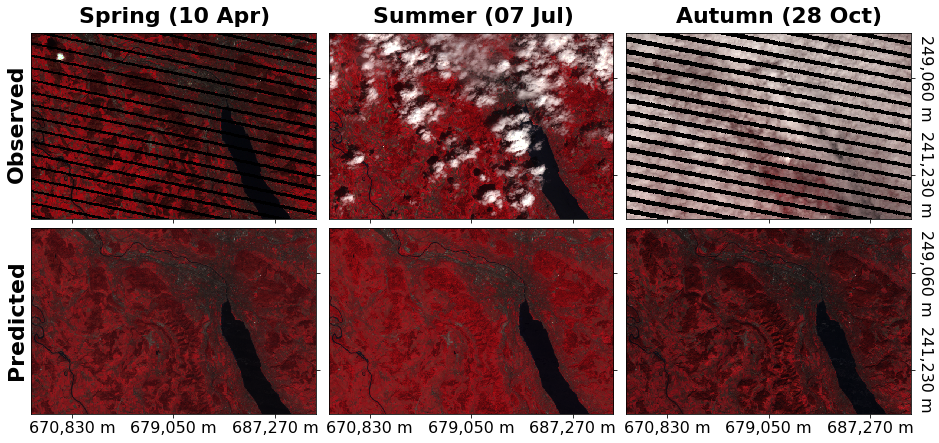

['02 May', '20 Jul', '22 Sep']


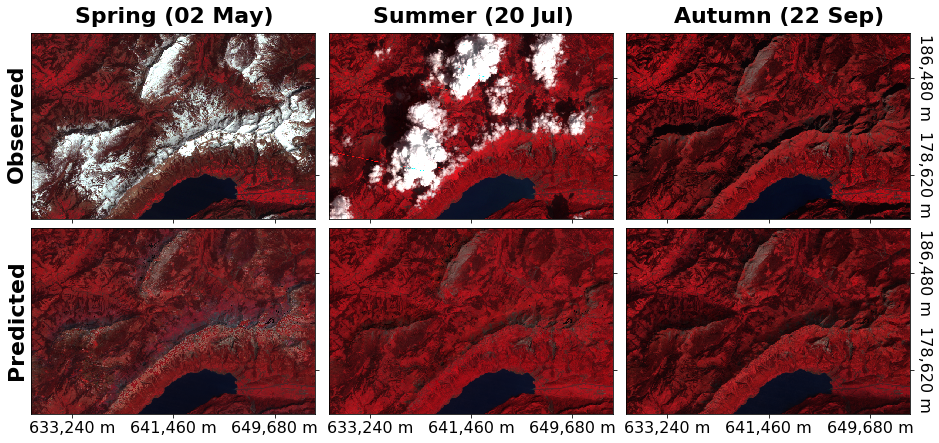

['01 Apr', '29 Jul', '02 Oct']


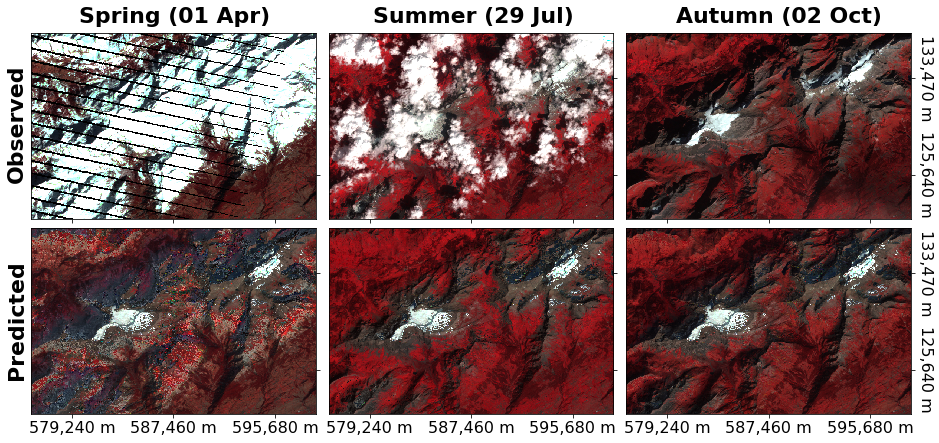

In [21]:
""" //////////////////////// qualitative validation plots //////////////////////// """


def plot_geotiff(ax,fname,show_ylabels=True):
    
    # reading in geotiff and rescale image it  [0 to 1]
    image, geotransform, epsg = geotiff2datacube(fname)
    image_rescaled = np.true_divide(image, 10000)
    
    # function to stretch image for better visualization
    def stretch(ar,limits):
        lower_lim, upper_lim = limits
        clipped_ar = np.clip(ar,lower_lim,upper_lim)
        stretched_ar = (clipped_ar-lower_lim)/(upper_lim-lower_lim)
        return stretched_ar

    # turn image into an rgb data cube
    xyz_shape = (image_rescaled.shape[0], image_rescaled.shape[1], 3)
    rgb_cube = np.ndarray(xyz_shape)
    rgb_cube[:,:,0] = stretch(image_rescaled[:,:,3],(0,0.75))
    rgb_cube[:,:,1] = stretch(image_rescaled[:,:,2],(0,0.75))
    rgb_cube[:,:,2] = stretch(image_rescaled[:,:,1],(0,0.75))
    # plot image
    ax.imshow(rgb_cube,interpolation='none')
    
    # label axes according to geotransform
    x_start, x_res, _, y_start, _, y_res = geotransform
    
    # x axis
    x_offset = 110
    x_ticks = [0+x_offset,xyz_shape[1]//2,xyz_shape[1]-x_offset]
    x_labels = [f'{x_start+x_res*i:,.0f} m' for i in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    
    # y axis
    y_offset = 120
    y_ticks = [0+y_offset,xyz_shape[0]-y_offset]
    y_labels = [f'{y_start+y_res*i:,.0f} m' for i in y_ticks] if show_ylabels==True else []
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, rotation=270, va="center", fontdict={'fontsize': fontsize})
    
    
    # end of function
    
    
""" //////////////////////// main //////////////////////// """

# run for different region of interests 
rois = ['roi1','roi2','roi3']
yearAS = 2004

# path to data
folder_validation = f'data/validation/qualitative/gee_components/'
folder_model = f'data/validation/qualitative/coefficients/'
folder_images = f'data/validation/qualitative/synthetic_images/'


for roi in rois:
    
    year = collection_year(roi,yearAS)
    

    # getting acquisition date of validation scenes
    df_doys = pd.read_csv(f'{folder_validation}validation_DOYs_{roi}_{year}.csv')
    doys_validation = sorted(list(set(list(df_doys['DOY']))))
    datetime_objects = [dt.datetime.strptime(f'{doy} {year}', '%j %Y') for doy in doys_validation]
    date_strings = [datetime_object.strftime('%d %b') for datetime_object in datetime_objects]
    print(date_strings)

    fontsize = 16
    fontsize_title = 22

    fig, axs = plt.subplots(2,3, figsize=(16,7), facecolor='w', edgecolor='k', sharex=True)
    plt.rcParams.update({'font.size': fontsize})
    fig.subplots_adjust(hspace=0.05, wspace=0)
    axs = axs.ravel()

    plot_geotiff(axs[0],f'{folder_validation}validation_spring_{roi}_{year}.tif',False)
    plot_geotiff(axs[1],f'{folder_validation}validation_summer_{roi}_{year}.tif',False)
    plot_geotiff(axs[2],f'{folder_validation}validation_autumn_{roi}_{year}.tif')

    plot_geotiff(axs[3],f'{folder_images}synthetic_image_{roi}_{year}_{doys_validation[0]}.tif',False)
    plot_geotiff(axs[4],f'{folder_images}synthetic_image_{roi}_{year}_{doys_validation[1]}.tif',False)
    plot_geotiff(axs[5],f'{folder_images}synthetic_image_{roi}_{year}_{doys_validation[2]}.tif')


    fig.text(0.255, 0.9, f'Spring ({date_strings[0]})', ha='center',fontweight='bold',fontsize=fontsize_title)
    fig.text(0.515, 0.9, f'Summer ({date_strings[1]})', ha='center',fontweight='bold',fontsize=fontsize_title)
    fig.text(0.78, 0.9, f'Autumn ({date_strings[2]})', ha='center',fontweight='bold',fontsize=fontsize_title)

    fig.text(0.11, 0.7, 'Observed', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)
    fig.text(0.11, 0.31, 'Predicted', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

    plt.savefig(f'plots/qualitative_validation_{roi}_{year}.png', dpi=300, bbox_inches = "tight")
    plt.show()


In [4]:
""" //////////////////////// quantitative validation //////////////////////// """

# compare observations to predicted surface reflectance values
# save data as csv

rois = ['roi1','roi2','roi3']
yearAS = 2004

# path to data
folder_components = 'data/validation/quantitative/gee_components/'
folder_coefficients = 'data/validation/quantitative/coefficients/'
folder_images = 'data/validation/quantitative/synthetic_images/'
folder_values = 'data/validation/quantitative/values/'


for roi in rois:
    
    year = collection_year(roi,yearAS)
    
    # assemble components to coefficients
    coefficients, model, geotransform, epsg = assemble_coefficients(folder_components,roi,year)
    save_geotiff(coefficients, geotransform, epsg, f'{folder_coefficients}coefficients_{roi}_{year}')
    save_geotiff(model, geotransform, epsg, f'{folder_coefficients}model_{roi}_{year}')
    
    # get doy of the validation images
    df_doys = pd.read_csv(f'{folder_components}validation_DOYs_{roi}_{year}.csv')
    doys_validation = sorted(list(set(list(df_doys['DOY']))))
    print(doys_validation)

    # generate synthetic images at dates of validation images
    for doy in doys_validation:
        coefficients_file = f'{folder_coefficients}coefficients_{roi}_{year}.tif'
        image, geotransform, epsg = coefficients2image(coefficients_file, doy, year)
        save_geotiff(image, geotransform, epsg, f'{folder_images}synthetic_image_{roi}_{year}_{doy}')
    
    

'100%'

In [5]:

observed_list = []
predicted_list = []
band_list = []
doy_list = []
roi_list = []

for roi in rois:
       
    year = collection_year(roi,yearAS)
        
    # get doy of the validation images
    df_doys = pd.read_csv(f'{folder_components}validation_DOYs_{roi}_{year}.csv')
    doys_validation = list(set(list(df_doys['DOY'])))   

    for iband, band in enumerate(spectral_bands):
        print(band,end=' ')
        # read in the validation data for the spectral band
        observed, geotransform, epsg = geotiff2datacube(f'{folder_components}validation_{roi}_{year}_{band}.tif')
    

    
        for idoy, doy in enumerate(doys_validation):
        
            # read in the synthetic image (predicted data)
            predicted, geotransform, epsg = geotiff2datacube(f'{folder_images}synthetic_image_{roi}_{year}_{doy}.tif')


            # loop over all pixels
            for index, _ in np.ndenumerate(observed[:,:,0]):
                irow = index[0]
                icol = index[1]
            
                if observed[irow,icol,idoy] != 0:
                
                    observed_value = 10000 if observed[irow,icol,idoy]>10000 else observed[irow,icol,idoy]
                    observed_list.append(observed_value)
                    predicted_list.append(predicted[irow,icol,iband])
                    band_list.append(band)
                    doy_list.append(doy)
                    roi_list.append(roi)
    print(f'end {roi}')
        
        
df_output = pd.DataFrame({
    'roi': roi_list,
    'band': band_list,
    'DOY': doy_list,
    'observed': observed_list,
    'predicted': predicted_list
})

df_output.to_csv(f'{folder_values}data_quantitative_validation_as{yearAS}.csv', encoding='utf-8', index=False)


blue green red nir swir1 swir2 end roi1
blue green red nir swir1 swir2 end roi2
blue green red nir swir1 swir2 end roi3


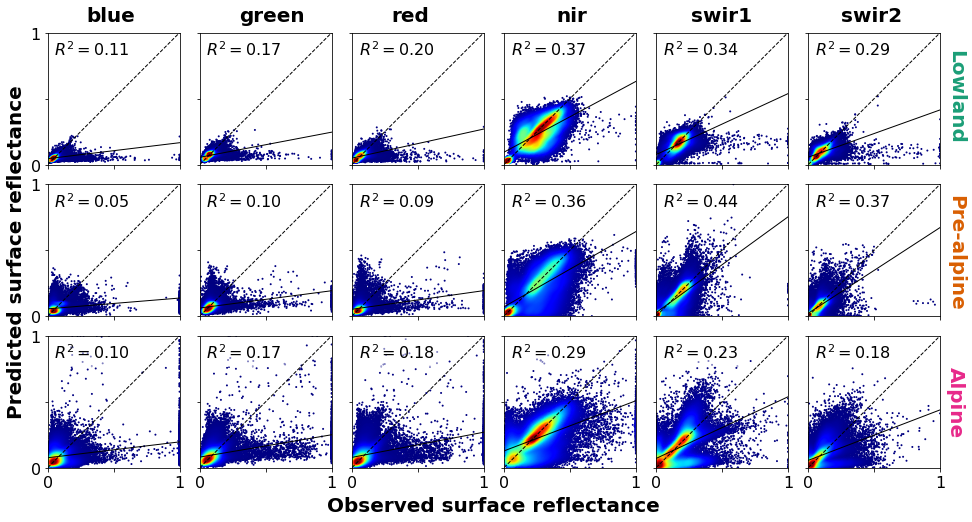

[('roi1', 'blue', 39260), ('roi1', 'green', 39260), ('roi1', 'red', 39261), ('roi1', 'nir', 39259), ('roi1', 'swir1', 39222), ('roi1', 'swir2', 39039), ('roi2', 'blue', 37989), ('roi2', 'green', 38030), ('roi2', 'red', 38021), ('roi2', 'nir', 38037), ('roi2', 'swir1', 37048), ('roi2', 'swir2', 36699), ('roi3', 'blue', 35155), ('roi3', 'green', 35218), ('roi3', 'red', 35256), ('roi3', 'nir', 35328), ('roi3', 'swir1', 34608), ('roi3', 'swir2', 33843)]


In [3]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
from scipy import stats
import os

%matplotlib inline



# function to get labels for a list of ticks
def get_labels(ticks):
    ticks = [str(t) for t in ticks]
    max_length = max([len(tick) for tick in ticks])
    labels = [tick + ('0'*(max_length-len(tick))) for tick in ticks]
    labels[0] = '0'
    labels[1] = ''
    labels[-1] = '1'
    return labels

# function to plot predicted (y) against reference (x) values
# additionally linear regression and 1 to 1 line are added
def scatterplot(ax,x,y,name='',fontsize=16):
    
    
    # convert to numpy arrays
    x = np.array(x)/10000; y = np.array(y)/10000
    
    value_limit = 1
    
    # compute r-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    r_square = r_value**2
    
    # compute linear regression
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit)
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    
    # colormap
    cm = plt.cm.get_cmap('jet')

    # x and y limits
    x_lin = [0,value_limit]; y_lin = [0,value_limit]
    
    ax.scatter(x, y, c=z, s=4, edgecolor='', cmap=cm)
    
    lw=1
    ax.plot(x_lin, y_lin, color='black', linestyle='--',linewidth=lw)
    ax.plot(x_lin, fit_fn(x_lin), color='black',linewidth=lw)
    ax.set_aspect('equal','box')
    
    # box with r square
    textstr = r'$R^2=%.2f$' % (r_square, )
    props = dict(boxstyle='square', facecolor='white', alpha=0.5, edgecolor='white')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=fontsize,
        verticalalignment='top', bbox=props)

    # titles
    # ax.set_title(name,fontweight='bold')

    value_min = 0
    step_ticks = (value_limit-value_min)/2
    # axes limits
    ax.set_xlim([value_min, value_limit])
    ax.set_ylim([value_min, value_limit])
    
    x_ticks = np.arange(value_min, value_limit+0.1, step_ticks)
    x_labels = get_labels(x_ticks)
    y_ticks = np.arange(value_min, value_limit+0.1, step_ticks)
    y_labels = get_labels(y_ticks)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels,fontdict={'fontsize': fontsize})

    
    return



# run for different region of interests 
rois = ['roi1','roi2','roi3']
yearAS = 2004

# path to data
folder_values = 'data/validation/quantitative/values/'

data = pd.read_csv(f'{folder_values}data_quantitative_validation_as{yearAS}.csv')


fontsize_title = 20
fontsize = 16

fig, axs = plt.subplots(3,6, figsize=(16,8), facecolor='w', edgecolor='k', sharex=True, sharey=True)
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.15, wspace=0.15)
axs = axs.ravel()

data_count = []
# main loop
for iroi, roi in enumerate(rois):
    for iband, band in enumerate(spectral_bands):
        ax = axs[iroi*len(spectral_bands)+iband]
    
        # create scatterplot
        df = data[data['roi']==roi]
        df_band = df[df['band']==band]
        data_count.append((roi,band,df_band.shape[0]))
        x = list(df_band['observed'])
        y = list(df_band['predicted'])
        scatterplot(ax,x,y,band)
        # end of for loop

band_names = ['Blue','Green','Red','NIR','SWIR 1', 'SWIR 2']
fig.text(0.18, 0.9, band_names[0], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.32, 0.9, band_names[1], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.44, 0.9, band_names[2], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.58, 0.9, band_names[3], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.71, 0.9, band_names[4], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.84, 0.9, band_names[5], ha='center',fontweight='bold',fontsize=fontsize_title)
        

fig.text(0.905, 0.77, 'Lowland', va='center', rotation=270, fontweight='bold', fontsize=fontsize_title,color='#1b9e77')
fig.text(0.905, 0.5, 'Pre-alpine', va='center', rotation=270, fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.905, 0.24, 'Alpine', va='center', rotation=270, fontweight='bold',fontsize=fontsize_title,color='#e7298a')    

fig.text(0.512, 0.05, 'Observed surface reflectance', ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.09, 0.5, 'Predicted surface reflectance', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'plots/model_evaluation_scatterplots.png', dpi=300, bbox_inches = "tight")
plt.show()

print(data_count)

Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


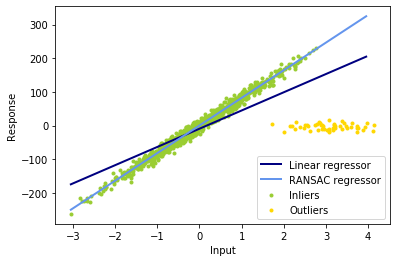

In [2]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

roi1 blue green red nir swir1 swir2 
roi2 blue green red nir swir1 swir2 
roi3 blue green red nir swir1 swir2 


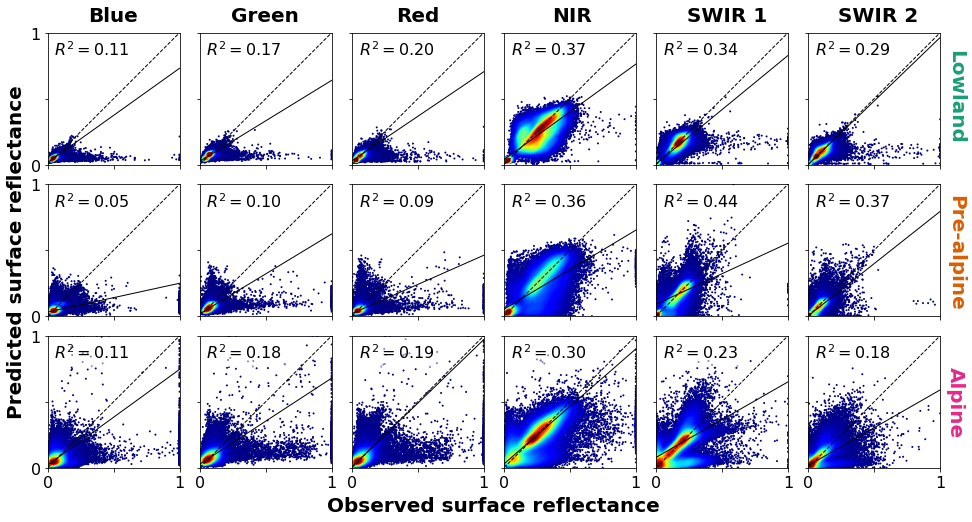

[('roi1', 'blue', 39260), ('roi1', 'green', 39260), ('roi1', 'red', 39261), ('roi1', 'nir', 39259), ('roi1', 'swir1', 39222), ('roi1', 'swir2', 39039), ('roi2', 'blue', 37989), ('roi2', 'green', 38030), ('roi2', 'red', 38021), ('roi2', 'nir', 38037), ('roi2', 'swir1', 37048), ('roi2', 'swir2', 36699), ('roi3', 'blue', 35155), ('roi3', 'green', 35218), ('roi3', 'red', 35256), ('roi3', 'nir', 35328), ('roi3', 'swir1', 34608), ('roi3', 'swir2', 33843)]


In [18]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
from scipy import stats
from sklearn import linear_model
import os

%matplotlib inline



# function to get labels for a list of ticks
def get_labels(ticks):
    ticks = [str(t) for t in ticks]
    max_length = max([len(tick) for tick in ticks])
    labels = [tick + ('0'*(max_length-len(tick))) for tick in ticks]
    labels[0] = '0'
    labels[1] = ''
    labels[-1] = '1'
    return labels

# function to plot predicted (y) against reference (x) values
# additionally linear regression and 1 to 1 line are added
def scatterplot(ax,x,y,name='',fontsize=16):
    
    
    # convert to numpy arrays
    x = np.array(x)/10000; y = np.array(y)/10000
    
    value_limit = 1
    
    # compute r-squared
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    r_square = r_value**2
    
    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    ransac.fit(np.array([x]).reshape(-1,1),y)
    
    # compute linear regression
    # fit = np.polyfit(x,y,1)
    # fit_fn = np.poly1d(fit)
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    
    # colormap
    cm = plt.cm.get_cmap('jet')

    # x and y limits
    x_lin = [0,value_limit]; y_lin = [0,value_limit]
    
    ax.scatter(x, y, c=z, s=4, edgecolor='', cmap=cm)
    
    lw=1
    ax.plot(x_lin, y_lin, color='black', linestyle='--',linewidth=lw)
    ax.plot(x_lin, ransac.predict(np.array([x_lin]).reshape(-1,1)), color='black',linewidth=lw)
    # ax.plot(x_lin, fit_fn(x_lin), color='red',linewidth=lw)
    ax.set_aspect('equal','box')
    
    # box with r square
    textstr = r'$R^2=%.2f$' % (r_square, )
    props = dict(boxstyle='square', facecolor='white', alpha=0.5, edgecolor='white')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=fontsize,
        verticalalignment='top', bbox=props)

    # titles
    # ax.set_title(name,fontweight='bold')

    value_min = 0
    step_ticks = (value_limit-value_min)/2
    # axes limits
    ax.set_xlim([value_min, value_limit])
    ax.set_ylim([value_min, value_limit])
    
    x_ticks = np.arange(value_min, value_limit+0.1, step_ticks)
    x_labels = get_labels(x_ticks)
    y_ticks = np.arange(value_min, value_limit+0.1, step_ticks)
    y_labels = get_labels(y_ticks)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontdict={'fontsize': fontsize})
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels,fontdict={'fontsize': fontsize})

    
    return



# run for different region of interests 
rois = ['roi1','roi2','roi3']
yearAS = 2004

# path to data
folder_values = 'data/validation/quantitative/values/'

data = pd.read_csv(f'{folder_values}data_quantitative_validation_as{yearAS}.csv')


fontsize_title = 20
fontsize = 16

fig, axs = plt.subplots(3,6, figsize=(16,8), facecolor='w', edgecolor='k', sharex=True, sharey=True)
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.15, wspace=0.15)
axs = axs.ravel()

data_count = []
# main loop
for iroi, roi in enumerate(rois):
    print(roi,end=' ')
    for iband, band in enumerate(spectral_bands):
        print(band,end=' ')
        ax = axs[iroi*len(spectral_bands)+iband]
        # create scatterplot
        df = data[data['roi']==roi]
        df_band = df[df['band']==band]
        data_count.append((roi,band,df_band.shape[0]))
        x = list(df_band['observed'])
        y = list(df_band['predicted'])
        scatterplot(ax,x,y,band)
        # end of for loop
    print()

band_names = ['Blue','Green','Red','NIR','SWIR 1', 'SWIR 2']
fig.text(0.182, 0.9, band_names[0], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.314, 0.9, band_names[1], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.446, 0.9, band_names[2], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.58, 0.9, band_names[3], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.715, 0.9, band_names[4], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.846, 0.9, band_names[5], ha='center',fontweight='bold',fontsize=fontsize_title)
        

fig.text(0.905, 0.77, 'Lowland', va='center', rotation=270, fontweight='bold', fontsize=fontsize_title,color='#1b9e77')
fig.text(0.905, 0.5, 'Pre-alpine', va='center', rotation=270, fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.905, 0.24, 'Alpine', va='center', rotation=270, fontweight='bold',fontsize=fontsize_title,color='#e7298a')    

fig.text(0.512, 0.05, 'Observed surface reflectance', ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.09, 0.5, 'Predicted surface reflectance', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'plots/model_evaluation_scatterplots.png', dpi=300, bbox_inches = "tight")
plt.show()

print(data_count)

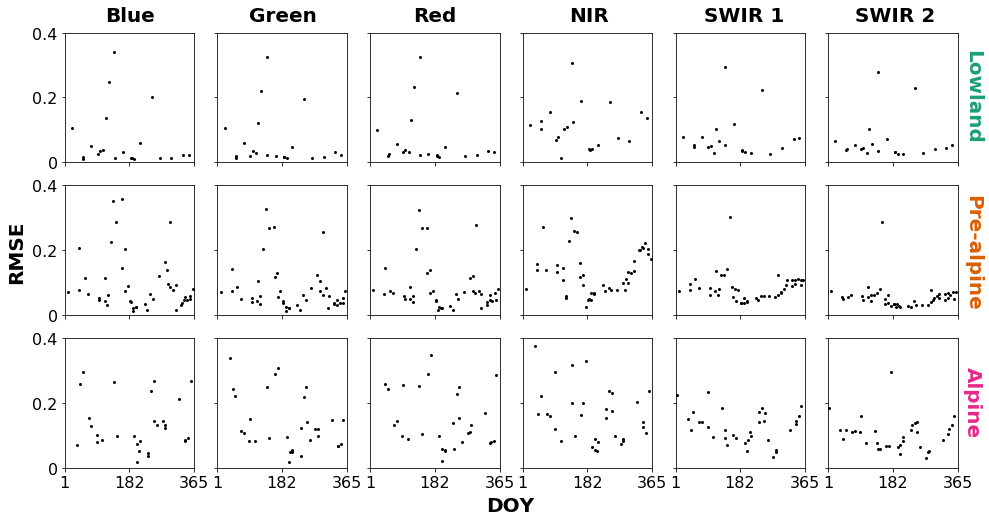

[('roi1', 'blue', 21), ('roi1', 'green', 21), ('roi1', 'red', 21), ('roi1', 'nir', 21), ('roi1', 'swir1', 21), ('roi1', 'swir2', 21), ('roi2', 'blue', 47), ('roi2', 'green', 47), ('roi2', 'red', 47), ('roi2', 'nir', 47), ('roi2', 'swir1', 47), ('roi2', 'swir2', 47), ('roi3', 'blue', 35), ('roi3', 'green', 35), ('roi3', 'red', 35), ('roi3', 'nir', 35), ('roi3', 'swir1', 35), ('roi3', 'swir2', 35)]


In [14]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
from scipy import stats
import os

%matplotlib inline


# function to get the root mean square error
def compute_rmse(x,y):
    # convert to numpy arrays
    x = np.array(x)/10000; y = np.array(y)/10000
    return np.sqrt(np.mean((y-x)**2))



# run for different region of interests 
rois = ['roi1','roi2','roi3']

# path to data
folder_values = 'data/validation/quantitative/values/'

data = pd.read_csv(f'{folder_values}data_quantitative_validation_as{yearAS}.csv')

fontsize_title = 20
fontsize = 16

fig, axs = plt.subplots(3,6, figsize=(16,8), facecolor='w', edgecolor='k', sharex=True, sharey=True)
plt.rcParams.update({'font.size': fontsize})
fig.subplots_adjust(hspace=0.18, wspace=0.18)
axs = axs.ravel()


data_count = []
# main loop

for iroi, roi in enumerate(rois):
    
    df = data[data['roi']==roi]
    doys = sorted(list(df['DOY'].unique()))
    
    for iband, band in enumerate(spectral_bands):
        ax = axs[iroi*len(spectral_bands)+iband]
        rmses = []
    
        df_band = df[df['band']==band]
        
        for idoy, doy in enumerate(doys):
            df_doy = df_band[df_band['DOY']==doy]
        
            x = list(df_doy['observed'])
            y = list(df_doy['predicted'])
            rmses.append(compute_rmse(x,y))
            
            
        x_ticks = [ 1, 182, 365]
        y_ticks = [0,0.2,0.4]
    
        ax.set_xlim([1,365])
        ax.set_ylim([0,0.4])
    
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks,fontdict={'fontsize': fontsize})
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks,fontdict={'fontsize': fontsize})
    
        ax.scatter(doys, rmses, marker='.', color='black', linewidths=0)
        
        data_count.append((roi,band,len(rmses)))
        # end of for loop

band_names = ['Blue','Green','Red','NIR','SWIR 1', 'SWIR 2']
fig.text(0.182, 0.9, band_names[0], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.314, 0.9, band_names[1], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.446, 0.9, band_names[2], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.58, 0.9, band_names[3], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.715, 0.9, band_names[4], ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.846, 0.9, band_names[5], ha='center',fontweight='bold',fontsize=fontsize_title)
        

fig.text(0.905, 0.77, 'Lowland', va='center', rotation=270, fontweight='bold', fontsize=fontsize_title,color='#1b9e77')
fig.text(0.905, 0.5, 'Pre-alpine', va='center', rotation=270, fontweight='bold',fontsize=fontsize_title,color='#d95f02')
fig.text(0.905, 0.24, 'Alpine', va='center', rotation=270, fontweight='bold',fontsize=fontsize_title,color='#e7298a') 

    
fig.text(0.512, 0.05, 'DOY', ha='center',fontweight='bold',fontsize=fontsize_title)
fig.text(0.075, 0.5, 'RMSE', va='center', rotation='vertical',fontweight='bold',fontsize=fontsize_title)

plt.savefig(f'plots/model_evaluation_rmse.png', dpi=300, bbox_inches = "tight")
plt.show()

print(data_count)